
# Gist of the paper

The [paper](https://www.nature.com/articles/s41586-023-06096-3), aimed to provide evidence of the speedup offered by quantum computing,as compared to classical, in implementing some problems. Here Totterized time evolution of a 2D Ising model was used as benchmark circuit. The [Ising model](https://phas.ubc.ca/~seme/516/smTutorial2.pdf) is extensively used in many body phenomenon like Time crystals,Majorna edge models,etc.

In this paper, time dynamics of a Hamiltonian were considered: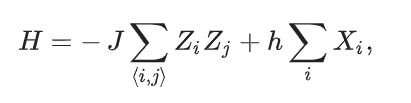

Here, J>0 is the coupling of the nearest neighbour spins with i< j and h is the global transverse field. We simulate the spin dynamics from an initial state by means of a first oder Trotter decomposition of the time evolution operator.


IBM's Eagle Processor kyiv processor was used for the experimentation(Here I have used IBM Brisbane). Probabilty Error Correction(where a reprsentative noise model is learned and effectively inverted by sampling from a distribution of noisy circuits related to the learned model) was considered, however ZNE(Zero-noise Extrapolation) was used, as it has a much lower sampling cost, though gives bias.ZNE is either a polynomial or exponential extrapolation method for noisy expectation values as a function of a noise parameter. This requires the controlled amplification of the intrinsic hardware noise by a known gain factor G to extrapolate to the ideal G = 0 result. This circumventes the need to learn circuit noise by subcircuit repetition and making some assumptions about the device.

The sparse [Pauli-Lindbald noise Model](https://www.nature.com/articles/s41567-023-02042-2) is used for noise shaping in ZNE.The model takes the form exp(L), in which L is a Lindbladian comprising Pauli jump operators Pi weighted by rates λ. (A lindbladian is used to generalize the Schrodinger Equation to open systems). This model was used to amplify the noise.By allowing non zero coeffs λ(i) only for Paulli terms P(i) whose supports corresponds to a single qubit or a pair of connected qubits, we obtain a sparse noise model that can be efficiently learned and that, despite its simplicity, is able to capture crosstalk errors. It is readily seen that exp[αL] is obtained by scaling all λi by α. For α ≥ 0, the resulting noise model is a composition of Pauli channels.

To compare with classical simulations, Clifford circuits(Clifford gates are the elements of the Clifford group, a set of mathematical transformations which normalize the n-qubit Pauli group, i.e., map tensor products of Pauli matrices to tensor products of Pauli matrices through conjugation i.e. they transform from Pauli to Pauli) were used.





# Impelemnting

In [1]:
!pip list

Package               Version
--------------------- -----------
annotated-types       0.6.0
appdirs               1.4.4
asttokens             2.4.1
autograd              1.6.2
autoray               0.6.9
cachetools            5.3.3
certifi               2024.2.2
cffi                  1.16.0
charset-normalizer    3.3.2
colorama              0.4.6
comm                  0.2.2
contourpy             1.2.1
cryptography          42.0.6
cycler                0.12.1
debugpy               1.8.1
decorator             5.1.1
dill                  0.3.8
executing             2.0.1
fonttools             4.51.0
future                1.0.0
ibm-cloud-sdk-core    3.20.0
ibm-platform-services 0.53.6
idna                  3.7
ipykernel             6.29.4
ipython               8.24.0
jedi                  0.19.1
jupyter_client        8.6.1
jupyter_core          5.7.2
kiwisolver            1.4.5
matplotlib            3.8.4
matplotlib-inline     0.1.7
mpmath                1.3.0
nest-asyncio          1.6.0
ne


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Transevrse field Ising models 



In [1]:
import qiskit 
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate,UnitaryGate
SYGate=UnitaryGate(YGate().power(1/2),label=r"SqrtY")
SYdgGate=UnitaryGate(SYGate.inverse(),label="SqrtdY")
def generate_1D_tfim_circuit(num_qubits,num_trotter_steps,rx_angle,num_classical_bits=0,layer_barriers=False,trotter_barriers=False):
    qc=QuantumCircuit(num_qubits,num_classical_bits)
    for trotter_steps in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc,rx_angle,layer_barriers)
        if trotter_barriers:
            qc.barrier()
    return qc
def add_1d_tfim_trotter_layer(qc,rx_angle,layer_barriers=False):
    #in papaer there is RZZ gate between nearest neighbours,followed by RX gate on all qubits(from equation 2)
    #adding rzz gates between the even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.sdg([i,i+1])#The s dagger gate
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()
    #adding in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.sdg([i,i+1])#The s dagger gate
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()
    qc.rx(rx_angle,list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

The circuit to be implemented is: 

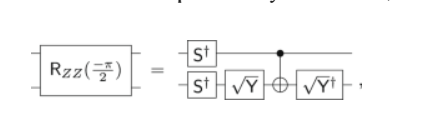

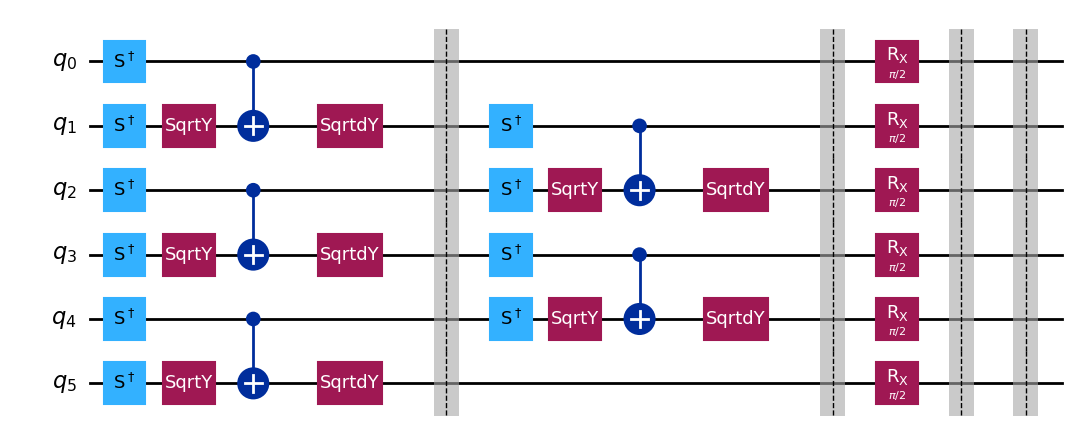

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#Verifying
num_trotter=1
rx_angle=np.pi*0.5
qc=generate_1D_tfim_circuit(6,num_trotter,rx_angle,trotter_barriers=True,layer_barriers=True)
qc.draw("mpl",fold=1)

In [3]:
#Generating same circuit but in reverse
def append_mirrored_1D_tfim_circuit(qc,num_qubits,num_trotter_steps,rx_angle,num_classical_bits=0,layer_barriers=False,trotter_barriers=False):
    #qc=QuantumCircuit(num_qubits)
    for trotter_steps in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc,rx_angle,layer_barriers)
        if trotter_barriers:
            qc.barrier()
    
def add_mirrored_1d_tfim_trotter_layer(qc,rx_angle,layer_barriers=False):
    qc.rx(-rx_angle,list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    #adding in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        
        qc.s([i,i+1])#The s dagger gate
    if layer_barriers:
        qc.barrier()
    for i in range(0,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])#The s dagger gate
        
    if layer_barriers:
        qc.barrier()
    
    

In [5]:
append_mirrored_1D_tfim_circuit(qc,6,num_trotter,rx_angle,layer_barriers=True)


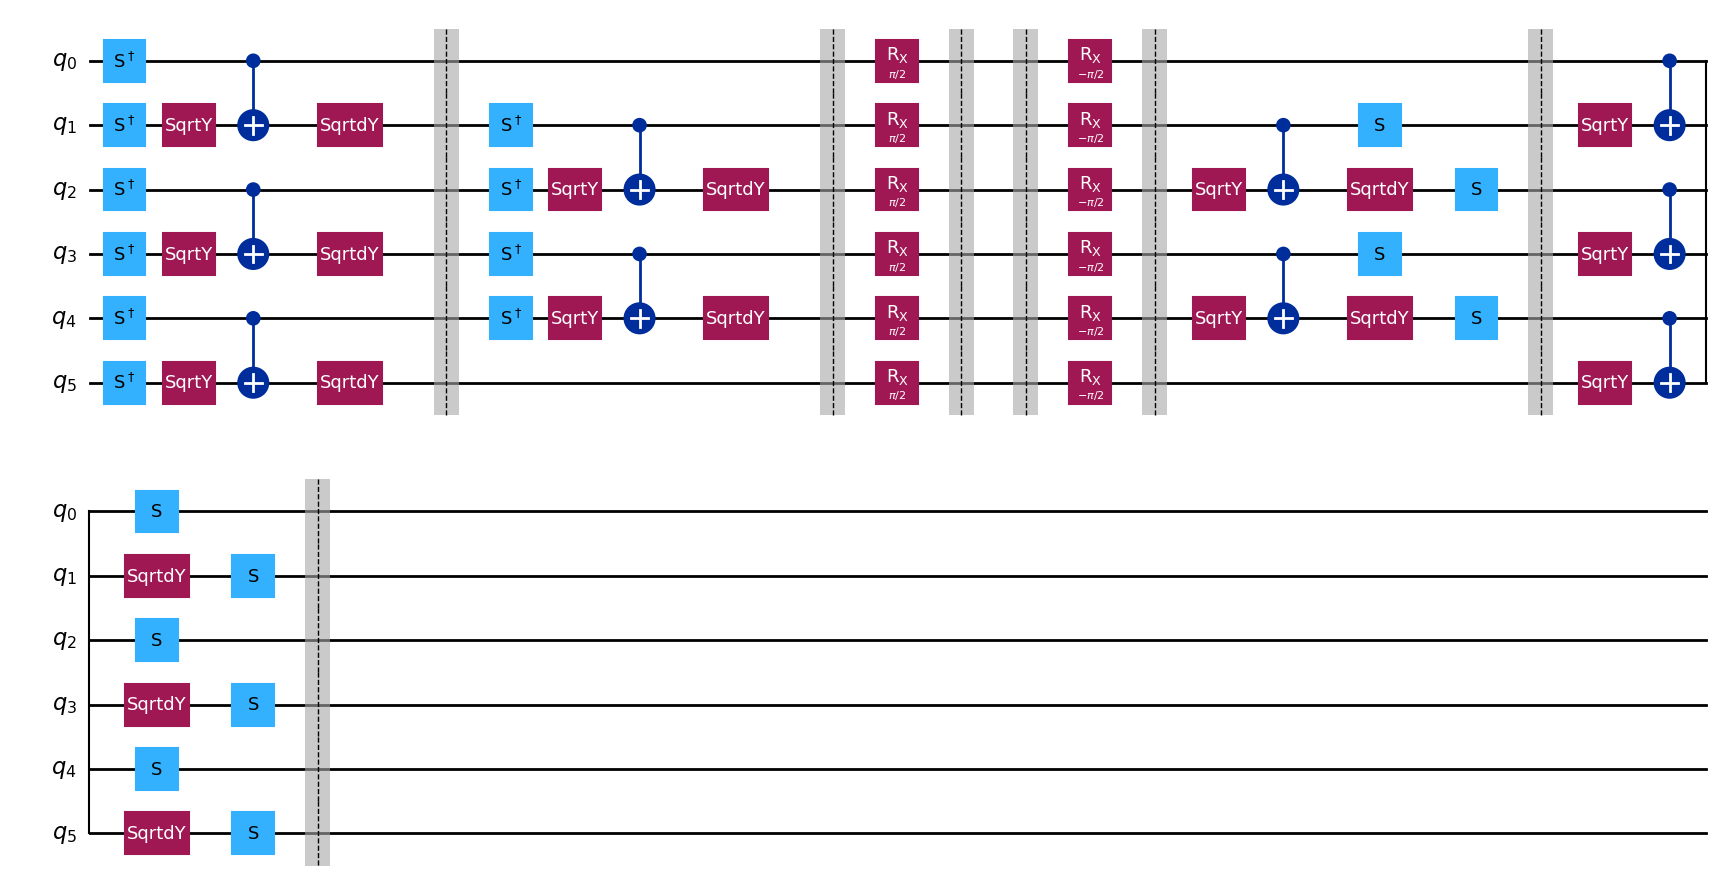

In [7]:
qc.draw(output="mpl")

# Mapping the problems to cicuits and observables

In [8]:
max_trotter_steps=10
#we are trying to measure noise as we increase the depth
max_qubits=100
num_qubits=100
measured_qubits=[49,50]
qc_list=[]
for trotter_steps in range(max_trotter_steps):
    qc=generate_1D_tfim_circuit(num_qubits,num_trotter,rx_angle,len(measured_qubits),True,True)
    append_mirrored_1D_tfim_circuit(qc,num_qubits,num_trotter,rx_angle,len(measured_qubits),True,True)
    #We measure the last 2 qubits
    qc.measure(measured_qubits,list(range(len(measured_qubits))))
    qc_list.append(qc)
    

In [9]:
qc_list[2].draw(output="mp",fold=-1)#Circuit for second trotter step

VisualizationError: 'Invalid output type mp selected. The only valid choices are text, latex, latex_source, and mpl'

# Optimize

In [7]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
backend_name="ibm_brisbane"
service=QiskitRuntimeService()
backend=service.get_backend(backend_name)
print("Inititation done......")
qc_transpiled_list=transpile(qc_list,backend=backend,optimization_level=1)



Inititation done......


# Hardware Execution

In [12]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.options.sampler_options import SamplerOptions

sampler=Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable=True
sampler.options.dynamical_decoupling.sequence_type="XY4"

job=sampler.run(qc_transpiled_list)
print(job.job_id)


<bound method BasePrimitiveJob.job_id of <RuntimeJobV2('crx57r7y7jt00080cq6g', 'sampler')>>


In [14]:
job_id="crx57r7y7jt00080cq6g"
job=service.job(job_id)

survival_probability_list=[]
for trotter_step in range(max_trotter_steps):
    try:
        data=job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()["0"*len(measured_qubits)]/data.c.num_shots)
    except:
        survival_probability_list.append(0)
        
        

Text(0, 0.5, 'Survival probab of all zero bit string')

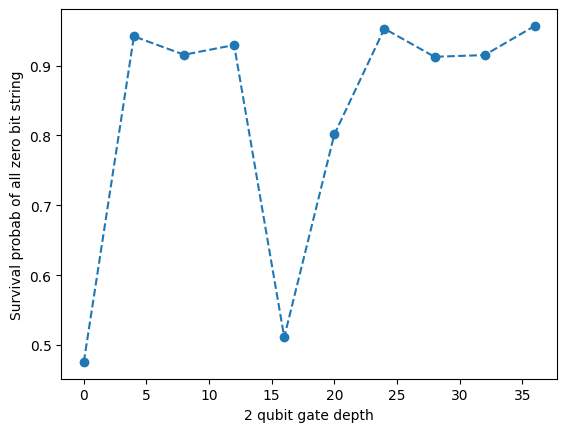

In [15]:
import matplotlib.pyplot as plt
plt.plot(list(range(0,4*max_trotter_steps,4)),survival_probability_list,'--o')
plt.xlabel("2 qubit gate depth")
plt.ylabel("Survival probab of all zero bit string")




# Using  Estimator (to get expectation values)

# Mapping the problem

In [9]:
from qiskit.circuit import Parameter
rx_angle=Parameter("rx_angle")
qc=generate_1D_tfim_circuit(num_qubits,2,rx_angle)

from qiskit.quantum_info import SparsePauliOp
middle_index=num_qubits//2
observable=SparsePauliOp("I"*middle_index+"Z"+"I"*(middle_index-1))


# Optimize the circuit

In [10]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
backend_name="ibm_brisbane"
service=QiskitRuntimeService()
backend=service.get_backend(backend_name)
print("Inititation done......")
qc_transpiled=transpile(qc,backend=backend,optimization_level=1)
observable=observable.apply_layout(qc_transpiled.layout)


Inititation done......


# Execute on Hardware

In [12]:
# here we have to define the range of Parameter
from qiskit_ibm_runtime import EstimatorV2,EstimatorOptions
min_rx=0
max_rx=np.pi/2

num_rx_angle=15
rx_angle_list=np.linspace(min_rx,max_rx,num_rx_angle)
print(rx_angle_list)

options=EstimatorOptions()
options.resilience_level=1
options.dynamical_decoupling.enable=True
options.dynamical_decoupling.sequence_type="XY4"

estimator=EstimatorV2(backend=backend,options=options)
#job=estimator.run([(qc_transpiled,observable,rx_angle_list)])
print(job.job_id())


[0.         0.11219974 0.22439948 0.33659921 0.44879895 0.56099869
 0.67319843 0.78539816 0.8975979  1.00979764 1.12199738 1.23419711
 1.34639685 1.45859659 1.57079633]
crx5szz7jqmg008zsdb0


# Post processing and ploting

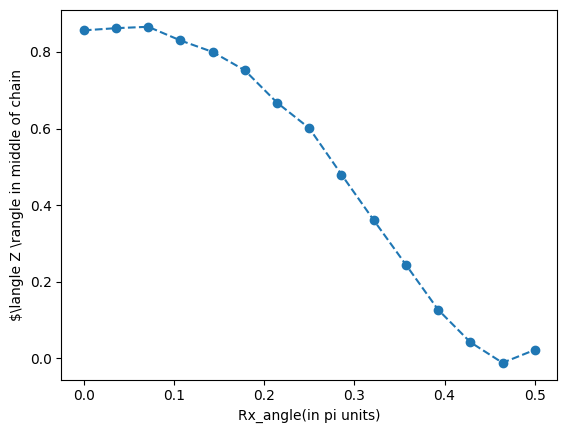

In [13]:
job_id="crx5szz7jqmg008zsdb0"
job=service.job(job_id)
exp_values=job.result()[0].data.evs
plt.plot(rx_angle_list/np.pi,exp_values,'--o')
plt.xlabel("Rx_angle(in pi units)")
plt.ylabel(r"$\langle Z \rangle in middle of chain")

plt.show()

As we can see,we got a graph almost the same as that in the paper,

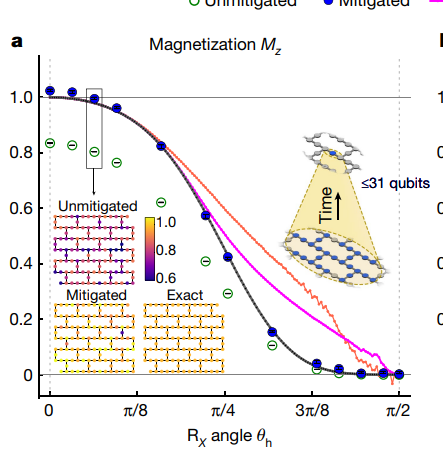


